In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64, complex128
from numba.cuda import jit as cuda_jit
import math

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 


from few.utils.ylm import GetYlms

from few import get_file_manager

from few.waveform import FastKerrEccentricEquatorialFlux

from few.utils.geodesic import get_fundamental_frequencies

from few.utils.constants import YRSID_SI

import os
import sys

# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

import GWfuncs
import loglike
import modeselector
import parismc
# import gc
# import pickle
import cupy as cp

# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info")



# Initialization

In [2]:
for backend in ["cpu", "cuda11x", "cuda12x", "cuda", "gpu"]: 
    print(f" - Backend '{backend}': {"available" if few.has_backend(backend) else "unavailable"}")  

 - Backend 'cpu': available
 - Backend 'cuda11x': unavailable
 - Backend 'cuda12x': available
 - Backend 'cuda': available
 - Backend 'gpu': available


In [3]:
# GPU configuration and missing variables
use_gpu = True
dt = 10     # Time step
T = 0.25     # Total time


In [4]:
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "use_gpu" : use_gpu,
        "force_backend": "cuda12x"  # Force GPU
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": "cuda12x" # Force GPU
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    "pad_output": True,
}

# Kerr eccentric flux
waveform_gen = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [5]:
gwf = GWfuncs.GravWaveAnalysis(T, dt)

In [ ]:
#Generating data (true)

m1_o = 1.5e6
m2_o = 1.5e1
a_o = 0.5
p0_o = 13
e0_o = 0.2
xI_o = 1.0
theta_o = 2*np.pi/3  # polar viewing angle
phi_o = -np.pi/2  # azimuthal viewing angle
dist = 1 # Gpc

params_star = (m1_o, m2_o, a_o, p0_o, e0_o, xI_o, theta_o, phi_o, dist)

In [7]:
loglike_obj = loglike.LogLike(params_star, waveform_gen, gwf, dt=dt, T=T, M_init=30, verbose=True)

In [8]:
loglike_obj.signal

array([-1.32381191e-22-2.18458321e-23j, -1.30489713e-22-2.85648985e-23j,
       -1.28057976e-22-3.51848388e-23j, ...,
       -4.38499174e-23+8.03161258e-23j, -4.84675996e-23+7.80252440e-23j,
       -5.28758858e-23+7.56008055e-23j])

# Test search

In [11]:
def parameter_space_search_example(n_samples=10):
    print(f"Running parameter space search with {n_samples} samples...")
    
    m1_range = (1.44e6, 1.56e6)
    m2_range = (14.8, 15.1)  
    a_range = (0.44, 0.56)
    p0_range = (12.65, 13.35)
    e0_range = (0.1992, 0.2008) #1sigma
    xI0_range = (1.0, 1.0) # keeping it equatorial for now
    theta_range = (np.pi / 3 * (0.999), np.pi / 3 * (1.001)) #check?
    phi_range = (np.pi / 4 * (0.999), np.pi / 4 * (1.001))
    dist_range = (0.98, 1.02)  
    #m1,a,p,e
    
    # Seed for reproducibility
    np.random.seed(7)  
    
    for i in range(n_samples):
        # Sample masses log-uniformly, others  uniformly
        m1 = 10**(np.random.uniform(np.log10(m1_range[0]), np.log10(m1_range[1])))
        m2 = 10**(np.random.uniform(np.log10(m2_range[0]), np.log10(m2_range[1])))
        params = np.array([
            m1,
            m2, 
            np.random.uniform(*a_range),
            np.random.uniform(*p0_range),
            np.random.uniform(*e0_range),
            np.random.uniform(*xI0_range),
            np.random.uniform(*theta_range),
            np.random.uniform(*phi_range),
            np.random.uniform(*dist_range)
        ])
        
        try:
            # Evaluate likelihood
            print(f" === Parameters for sample {i+1}: {params} ===")
            f_stat = loglike_obj(params)
            print(f"Sample {i+1}/{n_samples}: f_stat = {f_stat}")
                
        except Exception as e:
            print(f"Error in evaluation {i+1}: {e}")
            continue
    
    print("Parameter space search completed!")

In [12]:
parameter_space_search_example(n_samples=1)

Running parameter space search with 1 samples...
 === Parameters for sample 1: [1.44882232e+06 1.50334580e+01 4.92609108e-01 1.31564256e+01
 2.00764783e-01 1.00000000e+00 1.04719990e+00 7.84725943e-01
 9.90737559e-01] ===
DEBUG: theta_template shape: (9,)
DEBUG: theta_template: [1.44882232e+06 1.50334580e+01 4.92609108e-01 1.31564256e+01
 2.00764783e-01 1.00000000e+00 1.04719990e+00 7.84725943e-01
 9.90737559e-01]
Initial mode selected: (2, 2, 0) with power 80.81031673441753
Considering mode 1 / 30 : (2, 2, 1) with power 23.02721533261559
 - Inner product with selected mode 0: 0.00020031446614466943
Considering mode 2 / 30 : (2, 2, -1) with power 6.1201422953875415
 - Inner product with selected mode 0: 0.00019995784044797595
 - Inner product with selected mode 1: 0.00020007508315812584
Considering mode 3 / 30 : (2, 2, 2) with power 3.1768464569903854
 - Inner product with selected mode 0: 0.0002007082305644513
 - Inner product with selected mode 1: 0.00020193790639804694
 - Inner prod

# Sampling config

In [11]:
def prior_transform(u):
    m1lim = [1488133, 1511867]
    m2lim = [14.97, 15.03]
    alim = [0.49, 0.51]
    p0lim = [12, 14]
    e0lim = [0.20, 0.20]
    thetalim = [3*np.pi/5, 11*np.pi/15] #10% range from 2pi/3 (120deg)
    philim = [-11*np.pi/20, -9*np.pi/20] #10% range from -pi/2 (-90deg)
    distlim = [0.996, 1.004]

    transformed = np.zeros_like(u)

    # Log-uniform for masses
    transformed[:, 0] = 10**(np.log10(m1lim[0]) + u[:, 0] * (np.log10(m1lim[1]) - np.log10(m1lim[0])))
    transformed[:, 1] = 10**(np.log10(m2lim[0]) + u[:, 1] * (np.log10(m2lim[1]) - np.log10(m2lim[0])))
    
    # Uniform for other parameters
    transformed[:, 2] = (alim[1] - alim[0]) * u[:, 2] + alim[0]
    transformed[:, 3] = (p0lim[1] - p0lim[0]) * u[:, 3] + p0lim[0] 
    transformed[:, 4] = (e0lim[1] - e0lim[0]) * u[:, 4] + e0lim[0]
    transformed[:, 5] = 1.0  # Fixed xI value
    transformed[:, 6] = (thetalim[1] - thetalim[0]) * u[:, 6] + thetalim[0]
    transformed[:, 7] = (philim[1] - philim[0]) * u[:, 7] + philim[0]
    transformed[:, 8] = (distlim[1] - distlim[0]) * u[:, 8] + distlim[0]
    
    return transformed

In [12]:
config = parismc.SamplerConfig(
    proc_merge_prob=0.9,           # High probability for merging similar chains
    # higher probability -> needs larger distances. 
    # NOTE: keep 0.9 default
    alpha=1000,                    # Importance sampling parameter
    # NOTE: truncation parameter for summing the last alpha proposals for the importance weights
    # latest_prob_index=1000,        # Use recent samples for weighting
    # NOTE: same exact parameter :} will use alpha for the future..
    # TODO: might need to tune this? 
    trail_size=int(1e3),          # Maximum trials per iteration
    # numerical stability 
    boundary_limiting=True,        # Enable boundary constraints
    use_beta=True,                # Use beta correction for boundaries
    integral_num=int(1e5),        # MC samples for beta estimation
    # NOTE: related to cov estimation
    gamma=100,                    # Covariance update frequency
    exclude_scale_z=np.inf,       # No exclusion based on weights
    use_pool=False,               # Set to True for multiprocessing
    # n_pool=4                      # Number of processes (if use_pool=True)
    # NOTE: cpu only implementation. jax might be implemented in the future
    # TODO: pool in vanda?
)

In [ ]:
sigma = 0.01  # Initial covariance scale
ndim = 9
n_seed = 10  # Number of initial walkers/chains
# NOTE: change this? maybe 10x the expected number of modes?
# Initialize covariance matrices for each walker
init_cov_list = []
for i in range(n_seed):
    init_cov_list.append(sigma**2 * np.eye(ndim))

# TODO: might need to customize covariance list initially 
# maybe use sigmas from fisher matrix?


In [14]:
def log_reward(theta_batch):
    if theta_batch.ndim == 1:
        # Single parameter set
        return loglike_obj(theta_batch)

    # Batch evaluation
    results = []
    for i in range(theta_batch.shape[0]):
        result = loglike_obj(theta_batch[i])
        results.append(result)
    return np.array(results)

In [15]:
sampler = parismc.Sampler(
    ndim=ndim, 
    n_seed=n_seed,
    log_reward_func=log_reward,
    init_cov_list=init_cov_list,
    prior_transform=prior_transform,
    config=config
)

# Try not to run this...

In [26]:
# NOTE: what is this for?
# changed lhs_num from 1e5 to 1e2 for testing
sampler.prepare_lhs_samples(lhs_num=int(1e2), batch_size=10)
# TODO: customize LHS number 

    

Computing LHS rewards:   0%|          | 0/10 [00:00<?, ?it/s]

DEBUG: theta_template shape: (9,)
DEBUG: theta_template: [ 1.4965156e+06  1.4990675e+01  5.0410002e-01  1.3850000e+01
  2.0000000e-01  1.0000000e+00  1.9540707e+00 -1.4247123e+00
  9.9804002e-01]
Initial mode selected: (2, -2, 0) with power 52.1542801256059
Considering mode 1 / 30 : (2, -2, 1) with power 14.4088027652964
 - Inner product with selected mode 0: 0.0001998631779302719
Considering mode 2 / 30 : (2, -2, -1) with power 3.6983809063136883
 - Inner product with selected mode 0: 0.00020017412039132526
 - Inner product with selected mode 1: 0.00019980905809028474
Considering mode 3 / 30 : (2, 2, 0) with power 2.2480446078083665
 - Inner product with selected mode 0: 0.0001843701331753635
 - Inner product with selected mode 1: 0.0001887547204808308
 - Inner product with selected mode 2: 0.0001814990210746149
Considering mode 4 / 30 : (3, -3, 0) with power 2.1997357498143453
 - Inner product with selected mode 0: 2.6231517216325307e-05
 - Inner product with selected mode 1: 3.72657

In [27]:
sampler.run_sampling(
    num_iterations=100, 
    savepath='./parismc_results/',
    print_iter=10  # Print progress every n iterations
)


Sampling:   0%|          | 0/99 [00:00<?, ?it/s]

DEBUG: theta_template shape: (9,)
DEBUG: theta_template: [ 1.50530881e+06  1.50290974e+01  4.96604614e-01  1.36543346e+01
  2.00000000e-01  1.00000000e+00  1.93725277e+00 -1.44977781e+00
  9.96259902e-01]
Initial mode selected: (2, -2, 0) with power 51.06993710284218
Considering mode 1 / 30 : (2, -2, 1) with power 14.211657391052926
 - Inner product with selected mode 0: 0.00019988038041710858
Considering mode 2 / 30 : (2, -2, -1) with power 3.685100282897663
 - Inner product with selected mode 0: 0.0002001986510081977
 - Inner product with selected mode 1: 0.00019985177428957548
Considering mode 3 / 30 : (2, 2, 0) with power 2.5437425223740915
 - Inner product with selected mode 0: 0.00018396666212531061
 - Inner product with selected mode 1: 0.0001884400068717274
 - Inner product with selected mode 2: 0.00018107852707445742
Considering mode 4 / 30 : (3, -3, 0) with power 2.2028709481255913
 - Inner product with selected mode 0: 2.6631082342820828e-05
 - Inner product with selected mo

/nfs/home/svu/e1498138/localgit/parismc/parismc/sampler.py:611: RuntimeWarning: divide by zero encountered in log
  logZ = c_term - np.log(Nsum) + np.log(wsum)
/nfs/home/svu/e1498138/localgit/parismc/parismc/sampler.py:611: RuntimeWarning: invalid value encountered in scalar add
  logZ = c_term - np.log(Nsum) + np.log(wsum)


DEBUG: theta_template shape: (9,)
DEBUG: theta_template: [ 1.50875601e+06  1.50073705e+01  4.92360138e-01  1.29199453e+01
  2.00000000e-01  1.00000000e+00  2.21881722e+00 -1.47258580e+00
  9.96773518e-01]
Initial mode selected: (2, -2, 0) with power 109.19954591237035
Considering mode 1 / 30 : (2, -2, 1) with power 31.11557466301929
 - Inner product with selected mode 0: 0.000199972311804983
Considering mode 2 / 30 : (2, -2, -1) with power 8.351800772952355
 - Inner product with selected mode 0: 0.0002003233462021044
 - Inner product with selected mode 1: 0.00020007573731440685
Considering mode 3 / 30 : (2, -2, 2) with power 4.272275170346127
 - Inner product with selected mode 0: 0.00019792450130521727
 - Inner product with selected mode 1: 0.0001997102783027708
 - Inner product with selected mode 2: 0.0001973441847530267
Considering mode 4 / 30 : (3, -3, 0) with power 3.564574685028664
 - Inner product with selected mode 0: 2.8211730702412312e-05
 - Inner product with selected mode 1

# Analyze results

In [18]:
sampler = parismc.Sampler.load_state('./parismc_results/sampler_state.pkl')

In [35]:
def visualize_marginal_distributions(sampler, savepath):
    """
    Create marginal distribution plots for each dimension 
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
    except ImportError:
        print("Matplotlib/seaborn not available. Skipping visualization.")
        return

    print("\nCreating marginal distribution plots...")

    # Get samples and weights
    samples, weights = sampler.get_samples_with_weights(flatten=True)
    ndim = samples.shape[1]

    # Visualization parameters
    bin_num = 50
    decay = 3  # For exponential smoothing

    def exponential_smoothing(hist, decay=1.0):
        """Apply exponential smoothing to histogram."""
        smoothed = np.zeros_like(hist)
        for i in range(len(hist)):
            weights_exp = np.exp(-decay * np.abs(np.arange(len(hist)) - i))
            weights_exp /= np.sum(weights_exp)  # normalize
            smoothed[i] = np.sum(hist * weights_exp)
        return smoothed

    # Set up the plot
    sns.set(style="white", context="talk")

    # Create subplot grid
    n_rows = (ndim + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(24, 3*n_rows))

    # Flatten axes for easier indexing
    if ndim == 1:
        axes = [axes]
    elif ndim <= 2:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(ndim):
        ax = axes[i]

        # PARIS samples
        param_samples = samples[:, i]
        hist, bin_edges = np.histogram(param_samples, bins=bin_num, weights=weights, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        hist = exponential_smoothing(hist, decay=decay)
        ax.plot(bin_centers, hist, color='green', linewidth=2, label='PARIS')

        # Formatting
        ax.set_title(f'Dimension {i+1} Marginal Distribution', fontsize=14)
        ax.set_ylabel('Density', fontsize=12)
        # ax.set_xlim(0, 1)
        # ax.set_xticks([0, 0.5, 1])
        # ax.tick_params(axis='x', labelsize=10)
        ax.grid(True, alpha=0.3)

        # Add legend to first subplot
        if i == 0:
            ax.legend(fontsize=10, frameon=True)

    # Remove empty subplots if ndim is odd
    if ndim % 2 == 1 and ndim > 1:
        fig.delaxes(axes[-1])

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    plot_filename = os.path.join(savepath, 'marginal_distributions.png')
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Marginal distribution plot saved to: {plot_filename}")

    # Show plot if in interactive environment
    try:
        plt.show()
    except:
        pass

    # Create a 2D corner plot for the first few dimensions
    if ndim >= 2:
        create_corner_plot(samples, weights, savepath, max_dims=ndim)

def create_corner_plot(samples, weights, savepath, max_dims=4):
      """
      Create a corner plot showing 2D marginals.
      
      Parameters:
      ----------
      samples : array-like
          Sample points
      weights : array-like
          Sample weights
      savepath : str
          Save path
      max_dims : int
          Maximum number of dimensions to include
      """
      try:
          import matplotlib.pyplot as plt
          import seaborn as sns
      except ImportError:
          return

      print(f"Creating corner plot for first {max_dims} dimensions...")

      # Use only first max_dims dimensions
      samples_subset = samples[:, :max_dims]

      fig, axes = plt.subplots(max_dims, max_dims, figsize=(24, 24))

      for i in range(max_dims):
          for j in range(max_dims):
              ax = axes[i, j]

              if i == j:
                  # Diagonal: 1D marginal
                  hist, bin_edges = np.histogram(samples_subset[:, i], bins=30, weights=weights, density=True)
                  bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
                  ax.plot(bin_centers, hist, color='green', linewidth=2)
                #   ax.set_xlim(0, 1)
                  ax.set_title(f'Dim {i+1}')

              elif i > j:
                  # Lower triangle: 2D scatter
                  scatter = ax.scatter(samples_subset[:, j], samples_subset[:, i],
                                     c=weights, s=1, alpha=0.6, cmap='viridis')
                #   ax.set_xlim(0, 1)
                #   ax.set_ylim(0, 1)

              else:
                  # Upper triangle: empty
                  ax.axis('off')

              if i == max_dims - 1:
                  ax.set_xlabel(f'Dimension {j+1}')
              if j == 0 and i > 0:
                  ax.set_ylabel(f'Dimension {i+1}')

      plt.tight_layout()
      corner_filename = os.path.join(savepath, 'corner_plot.png')
      plt.savefig(corner_filename, dpi=300, bbox_inches='tight')
      print(f"Corner plot saved to: {corner_filename}")

      try:
          plt.show()
      except:
          pass


Creating marginal distribution plots...
Marginal distribution plot saved to: ./parismc_results/marginal_distributions.png


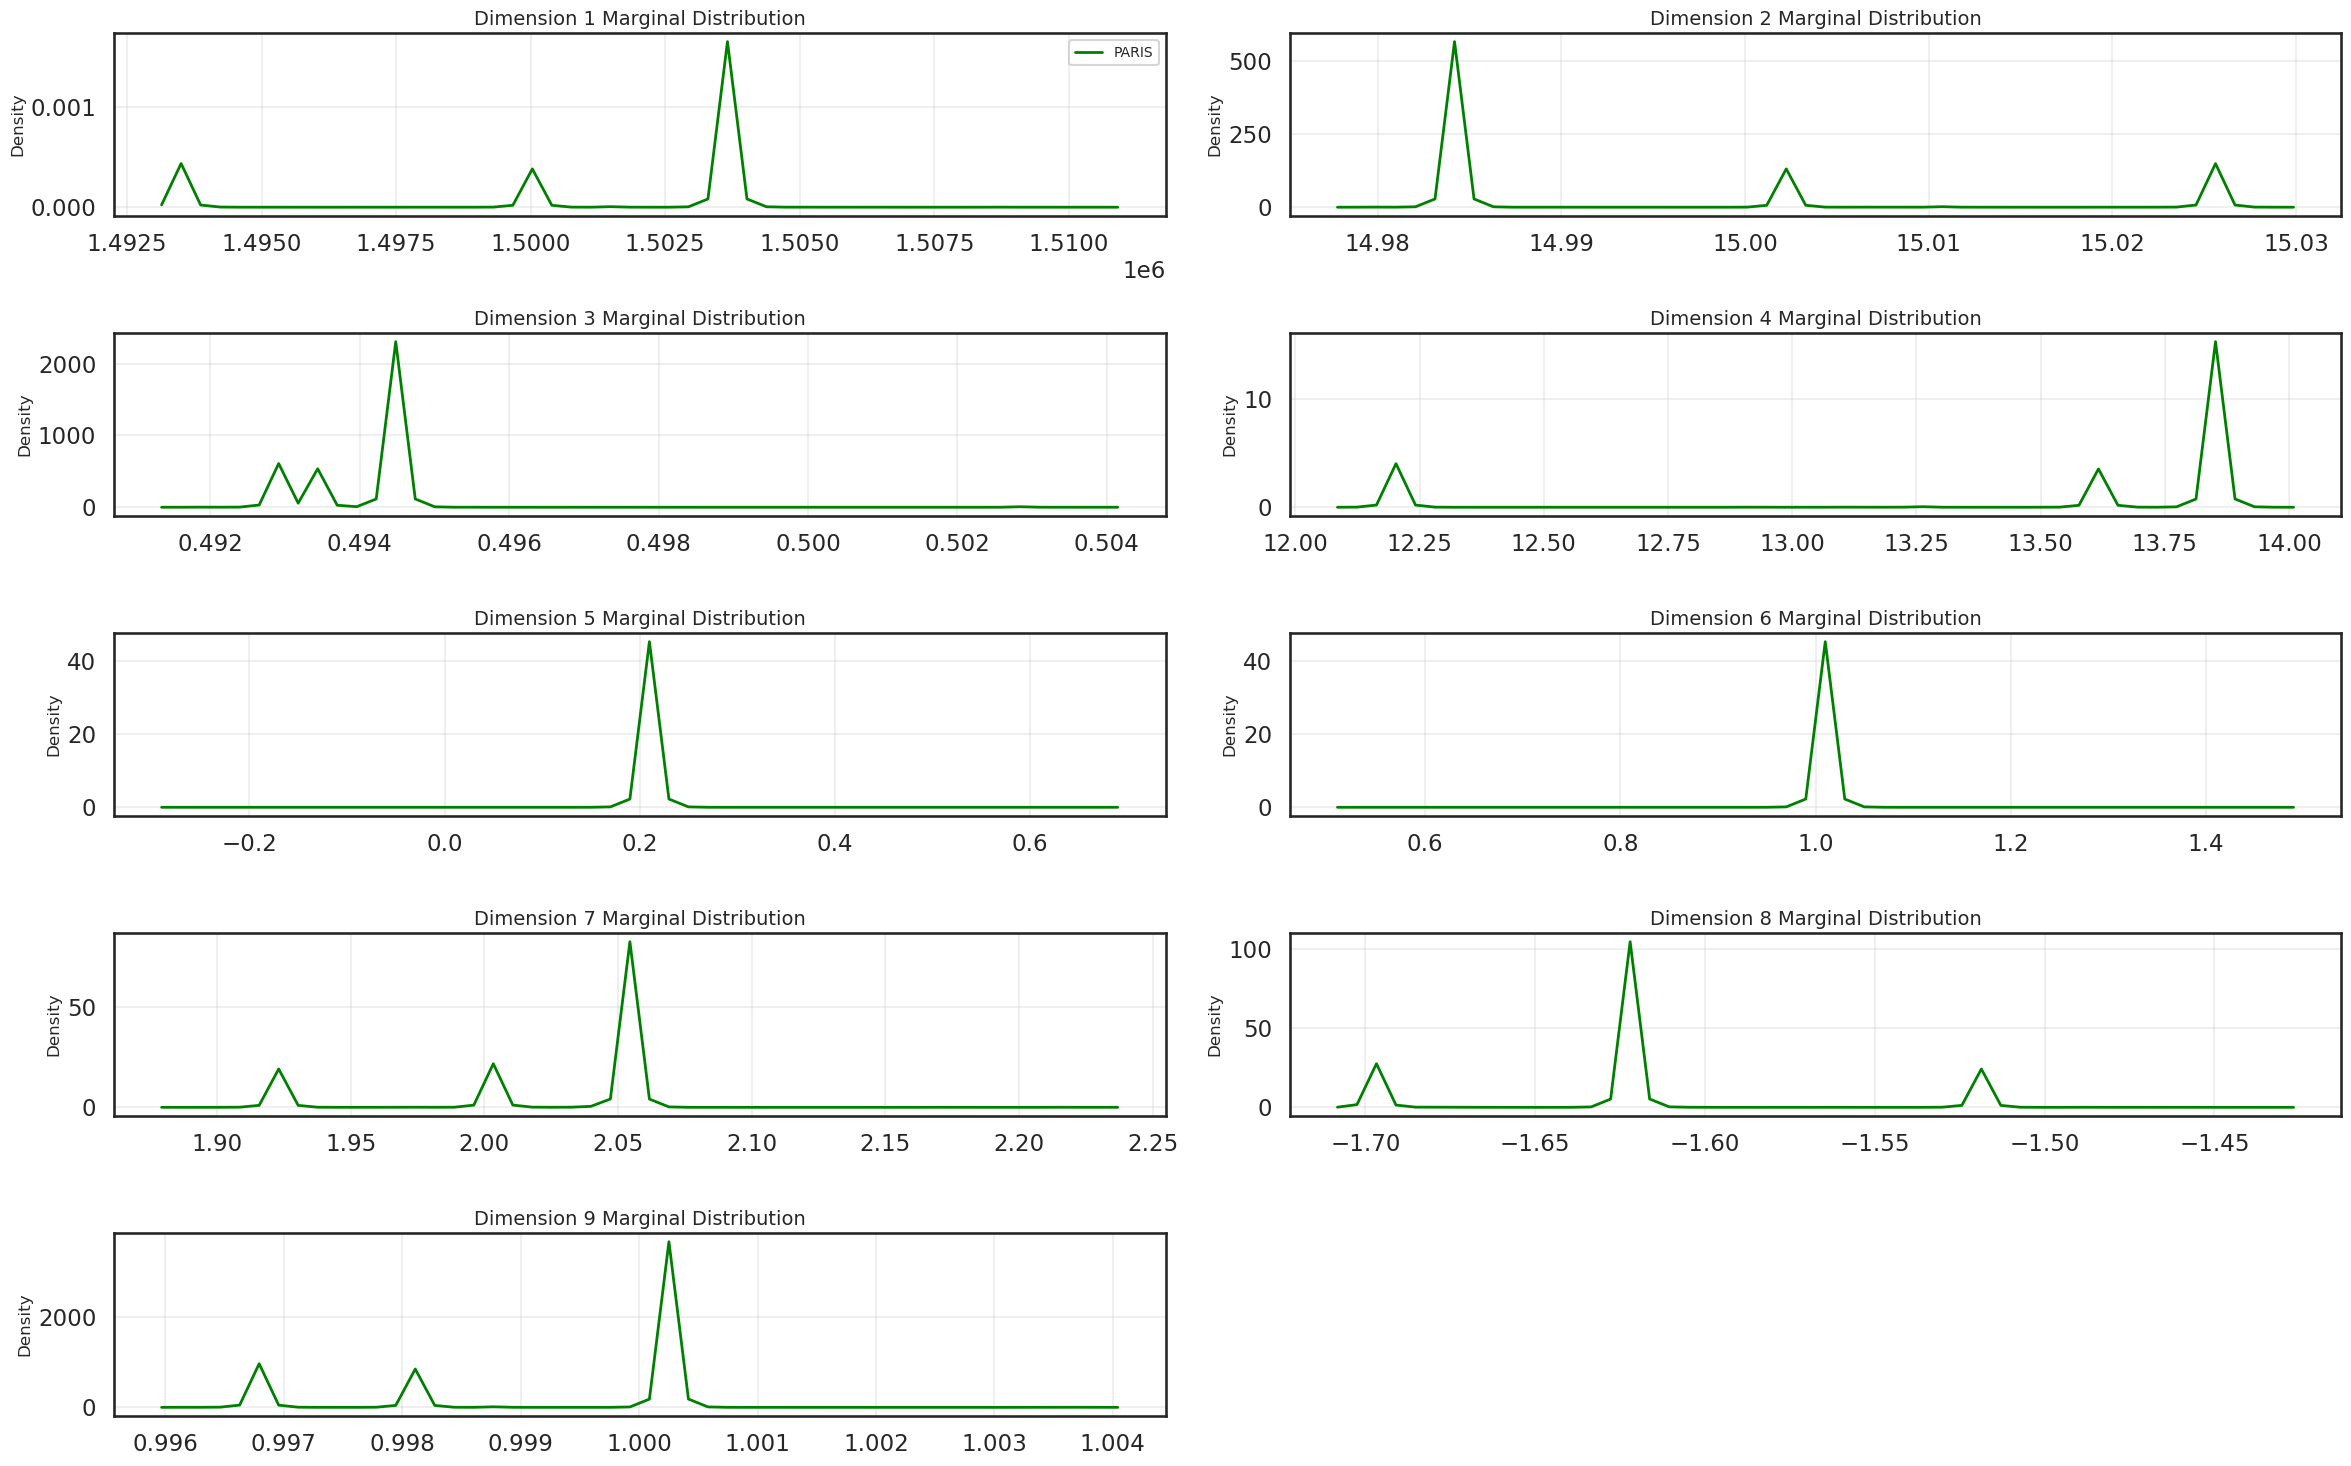

Creating corner plot for first 9 dimensions...
Corner plot saved to: ./parismc_results/corner_plot.png


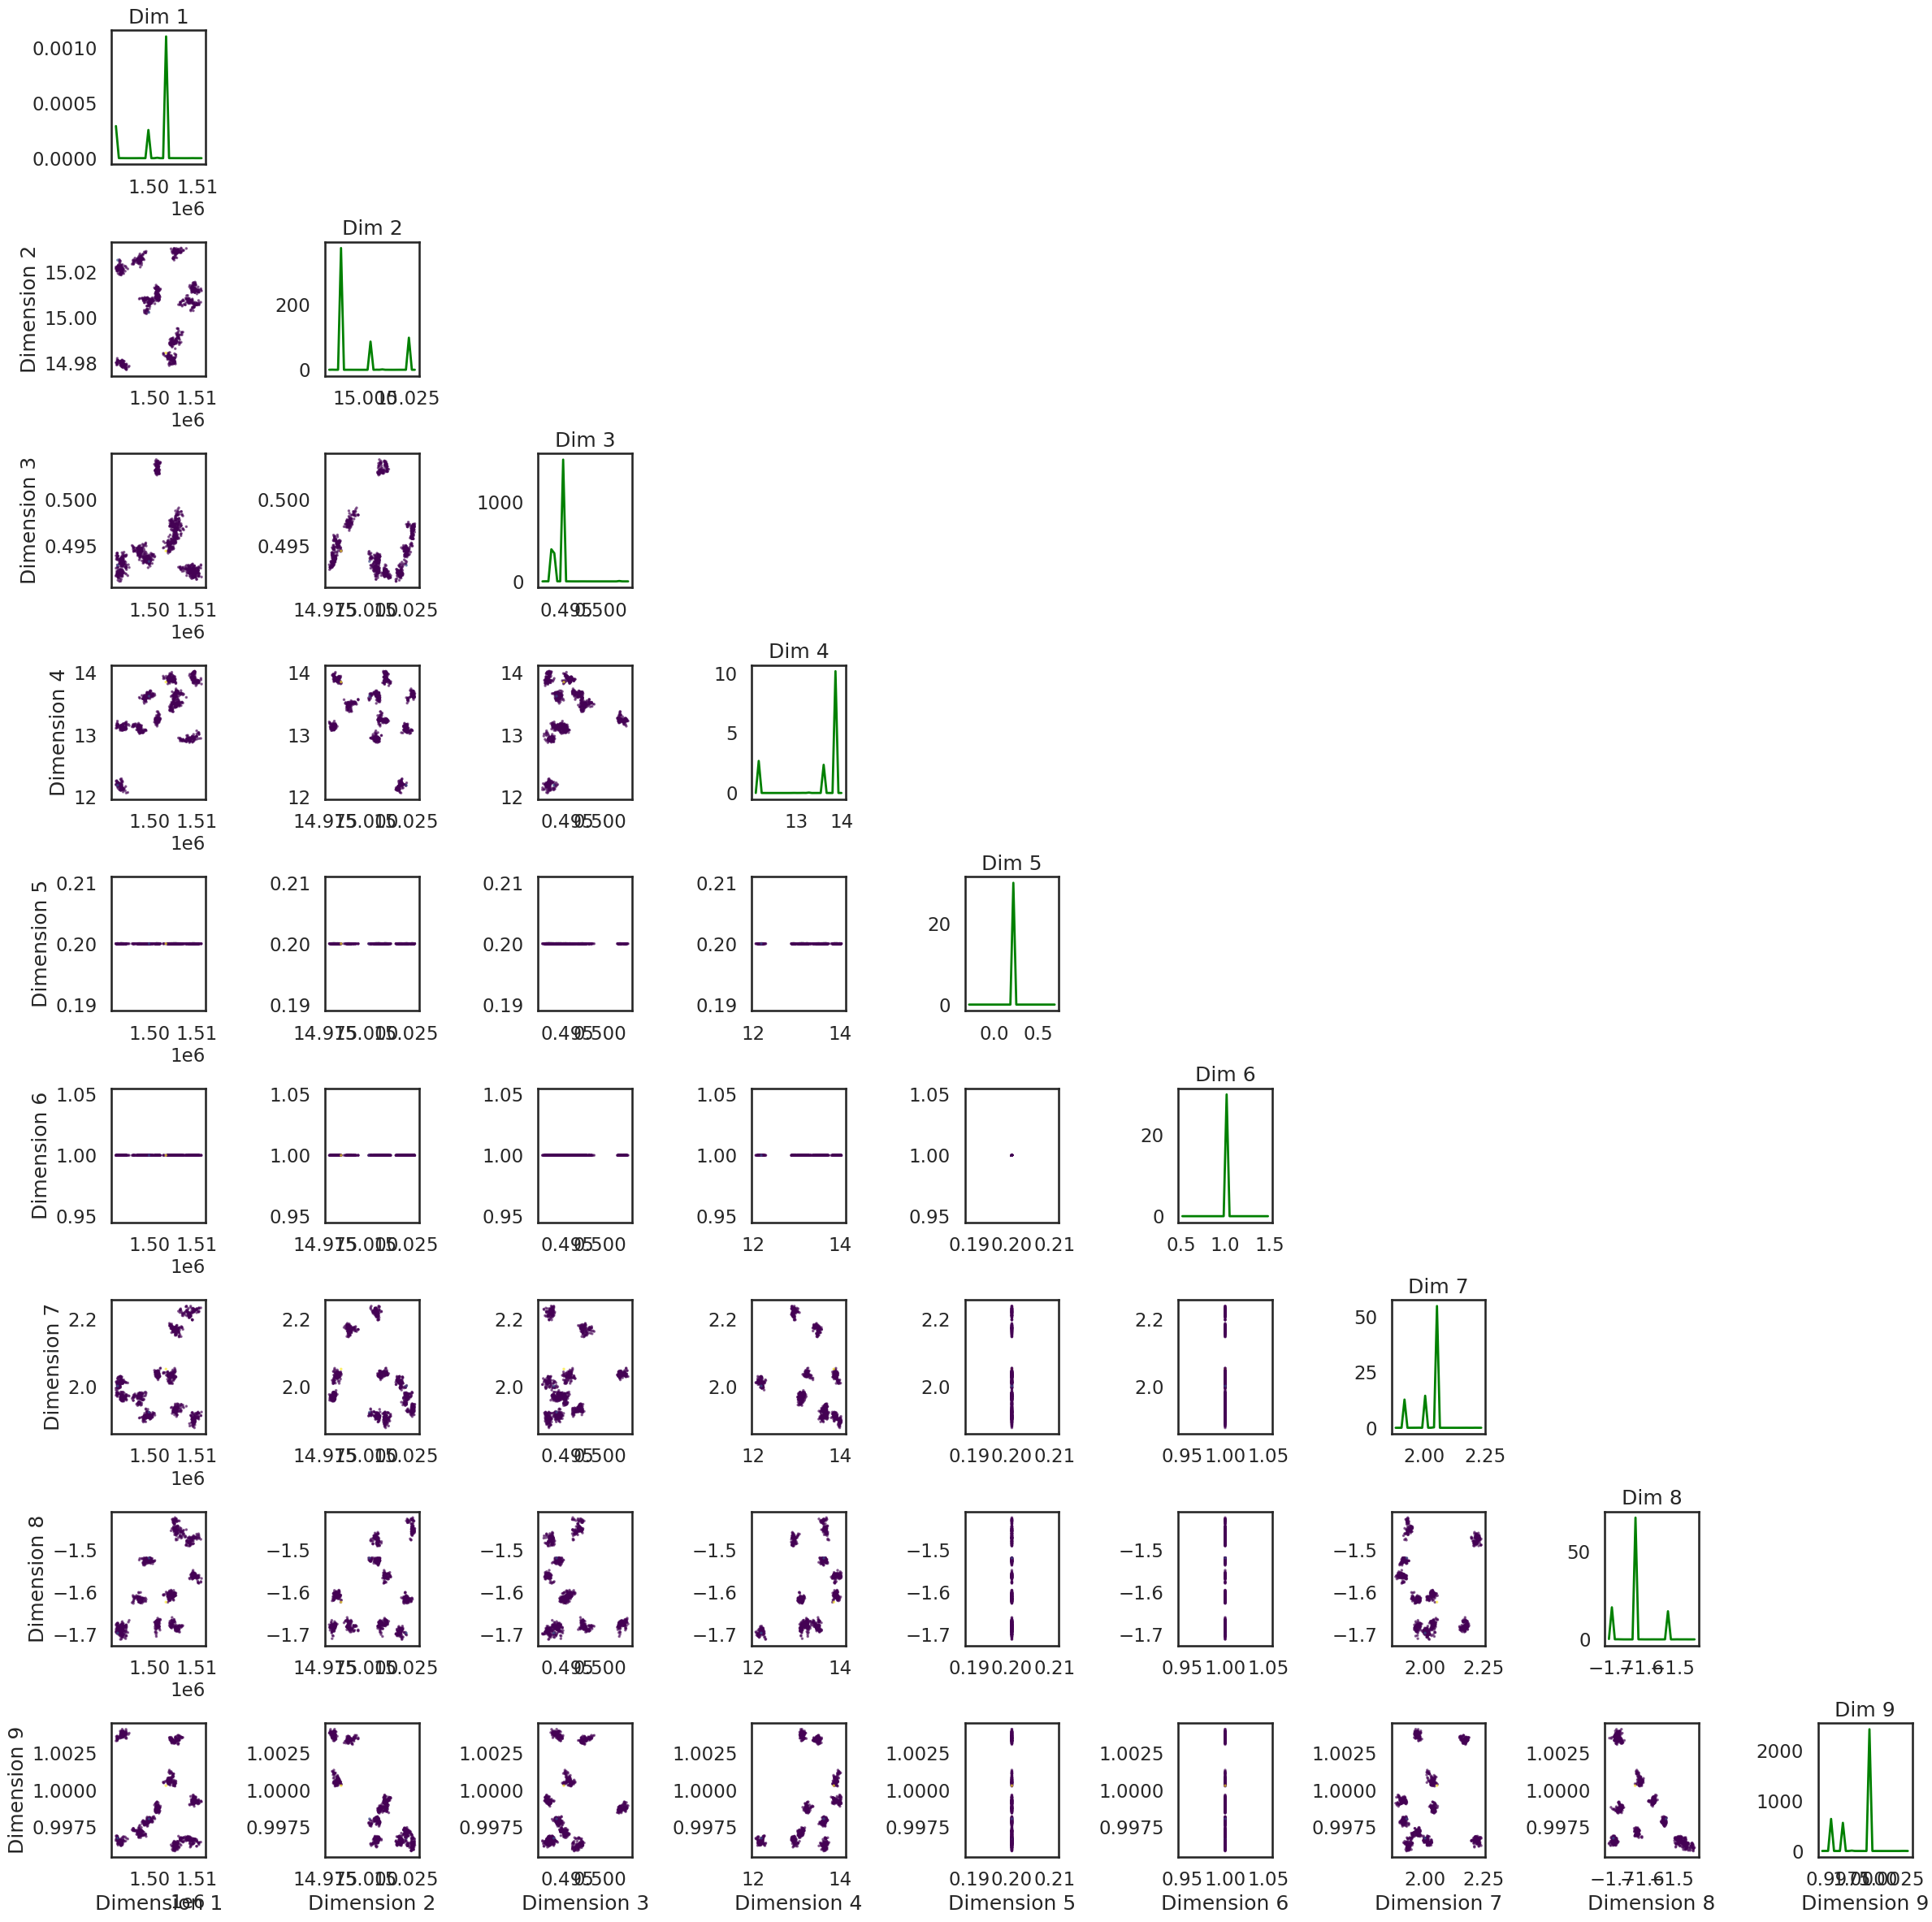

In [36]:
# Create visualizations
visualize_marginal_distributions(sampler, './parismc_results/')
# TODO: change the visualization function to delete MODES or smth
